# 🚀 MODEL AI - Prediksi Gaji Developer - Visualisasi Data

## 📄 Informasi Kelompok

**Nama Anggota Kelompok:**
- Okky Rangga Pratama - NIM: 1203220011
- Bagus Christiannanta - NIM: 1203220161  
- Dimas Arifil Azizi - NIM: 1203220097

**Fakultas:** Informatika  
**Program Studi:** Informatika  
**Kelas:** IF-02-01  
**Angkatan:** 2022  
  
**Sumber Dataset:** [Stack Overflow Developer Survey](https://survey.stackoverflow.co/)

---

### Impor Library

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Load dan Preprocessing Data

In [8]:
df = pd.read_csv("survey_results_public_2023.csv")
df = df[['ConvertedCompYearly', 'Country', 'YearsCode', 'YearsCodePro',
        'EdLevel', 'RemoteWork', 'OrgSize', 'DevType']]
df.dropna(inplace=True)

# Filter out outlier gaji
gaji_threshold = df['ConvertedCompYearly'].quantile(0.98)
df = df[df['ConvertedCompYearly'] < gaji_threshold]

# Konversi tahun ke numerik
def convert_years(val):
    if pd.isna(val):
        return np.nan
    elif val == 'Less than 1 year':
        return 0.5
    elif val == 'More than 50 years':
        return 51
    else:
        try:
            return float(val)
        except ValueError:
            return np.nan

df['YearsCode'] = df['YearsCode'].apply(convert_years)
df['YearsCodePro'] = df['YearsCodePro'].apply(convert_years)
df.dropna(subset=['YearsCode', 'YearsCodePro'], inplace=True)
df['YearsCode'] = np.log1p(df['YearsCode'])
df['YearsCodePro'] = np.log1p(df['YearsCodePro'])

# Simplifikasi country
top_countries = df['Country'].value_counts().nlargest(20).index
df['Country'] = df['Country'].apply(lambda x: x if x in top_countries else 'Other')

# Multi-hot encoding DevType
df['DevType_list'] = df['DevType'].str.split(';')
mlb = MultiLabelBinarizer()
devtype_encoded = mlb.fit_transform(df['DevType_list'])
devtype_df = pd.DataFrame(devtype_encoded, columns=mlb.classes_, index=df.index)
df = pd.concat([df.drop(columns=['DevType', 'DevType_list']), devtype_df], axis=1)

### Model Training

In [9]:
y = np.log1p(df['ConvertedCompYearly'])
X = df.drop(columns=['ConvertedCompYearly'])

numeric_features = ['YearsCode', 'YearsCodePro']
categorical_features = ['Country', 'EdLevel', 'RemoteWork', 'OrgSize']
devtype_features = [col for col in X.columns if col not in numeric_features + categorical_features]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

### Evaluasi Model & Visualisasi Hasil (Scatter Plot)

🔍 Random Forest
  MAE : $29,312.67
  RMSE: $43,026.35
  R²  : 0.4952
----------------------------------------


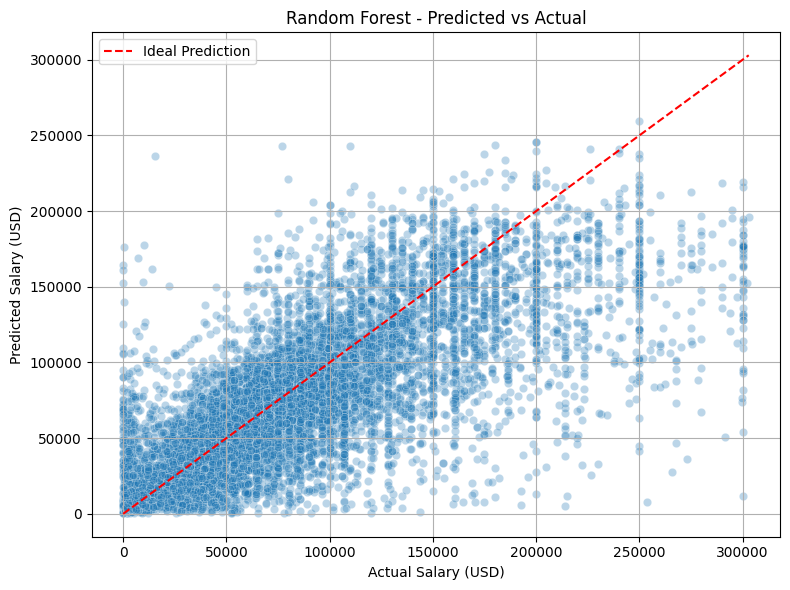

🔍 Linear Regression
  MAE : $29,757.34
  RMSE: $43,426.60
  R²  : 0.4858
----------------------------------------


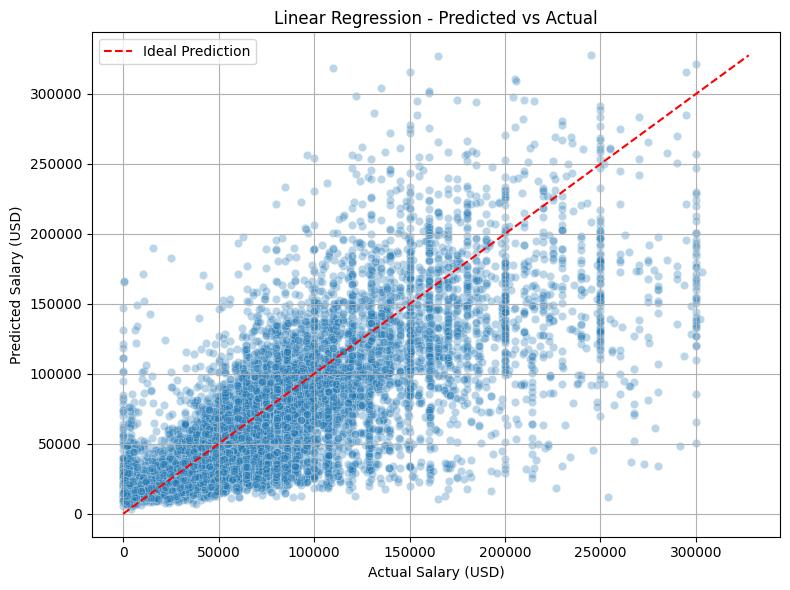

🔍 XGBoost Regressor
  MAE : $27,600.63
  RMSE: $41,071.62
  R²  : 0.5400
----------------------------------------


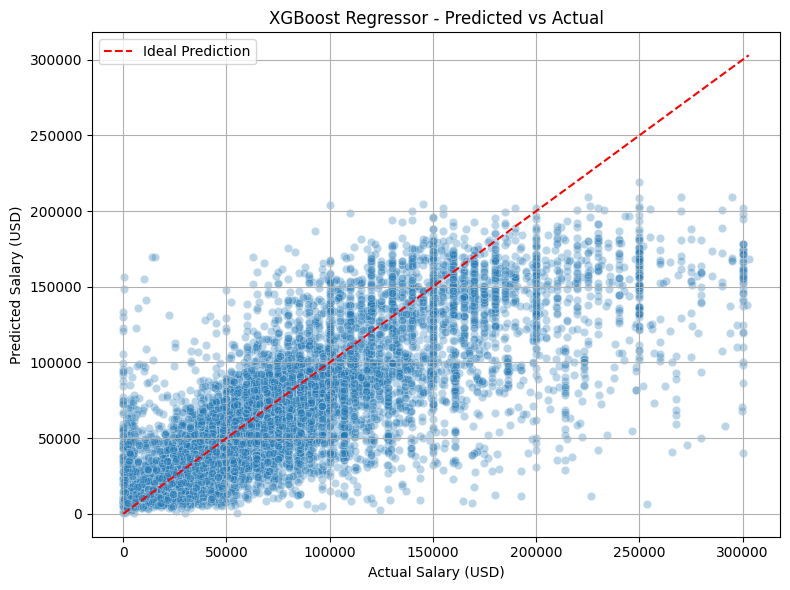

In [10]:
def evaluate_model(name, model):
    pipeline.steps[-1] = ('regressor', model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    y_true_exp = np.expm1(y_test)
    y_pred_exp = np.expm1(y_pred)

    mae = mean_absolute_error(y_true_exp, y_pred_exp)
    rmse = np.sqrt(mean_squared_error(y_true_exp, y_pred_exp))
    r2 = r2_score(y_true_exp, y_pred_exp)

    print(f"🔍 {name}")
    print(f"  MAE : ${mae:,.2f}")
    print(f"  RMSE: ${rmse:,.2f}")
    print(f"  R²  : {r2:.4f}")
    print("-" * 40)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true_exp, y=y_pred_exp, alpha=0.3)
    max_val = max(y_true_exp.max(), y_pred_exp.max())
    plt.plot([0, max_val], [0, max_val], 'r--', label='Ideal Prediction')
    plt.xlabel('Actual Salary (USD)')
    plt.ylabel('Predicted Salary (USD)')
    plt.title(f'{name} - Predicted vs Actual')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

evaluate_model("Random Forest", RandomForestRegressor(n_estimators=100, random_state=42))
evaluate_model("Linear Regression", LinearRegression())
evaluate_model("XGBoost Regressor", XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))

### Feature Importance (XGBoost)

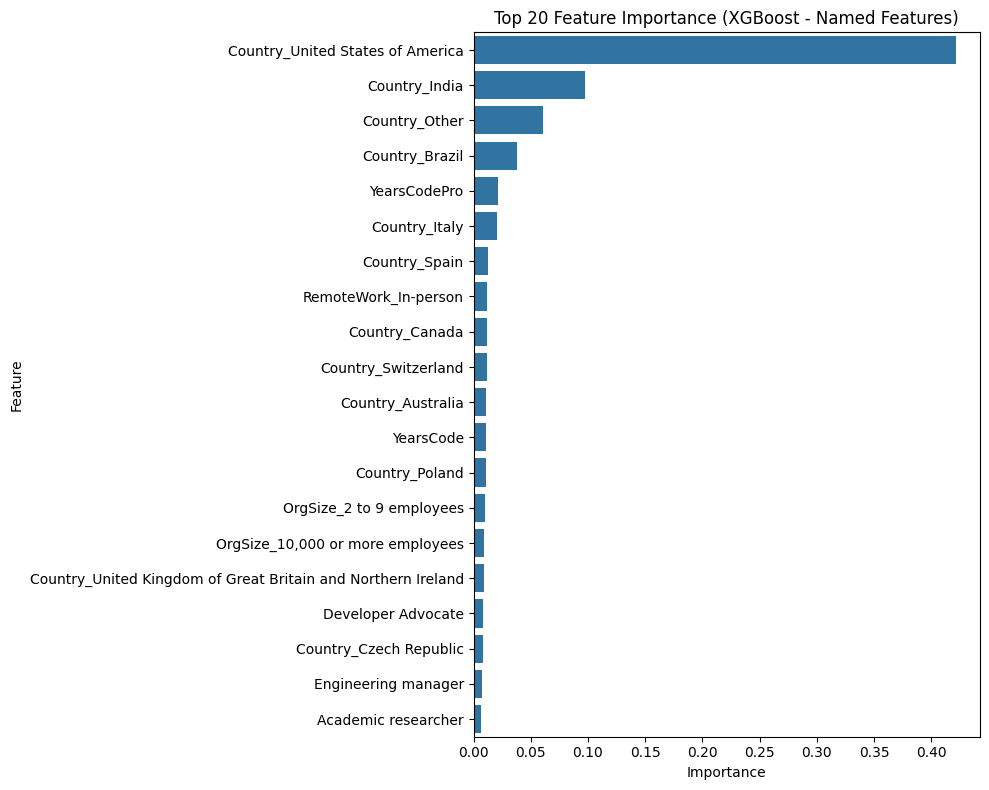

In [12]:
# Re-train XGBoost on preprocessed data
X_train_processed = preprocessor.fit_transform(X_train)
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_processed, y_train)

# Tambahan: tampilkan nama asli fitur
ohe = preprocessor.named_transformers_['cat']
cat_names = ohe.get_feature_names_out(categorical_features)
final_feature_names = numeric_features + list(cat_names) + list(
    X_train.columns[len(numeric_features) + len(categorical_features):]
)

# Dapatkan importance dengan nama asli
importances = xgb_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': final_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(20)

# Visualisasikan dengan nama asli
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Top 20 Feature Importance (XGBoost - Named Features)")
plt.tight_layout()
plt.show()